In [1]:
from src.DataFolder import DataFolder
from src.NeuralSignal import NeuralSignal
from src.runtime_logger import logger_setup

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neurodsp.spectral import compute_spectrum

data_path = "/home/miranjo/phasic_tonic/data/processed"
config_path = "/home/miranjo/phasic_tonic/configs/test.yaml"

## Setup

### Load the config file

In [2]:
with open(config_path, 'r') as f:
    args = yaml.safe_load(f)

fs                  = args.pop("fs")
f_theta             = (args.pop("f_theta_lower"), args.pop("f_theta_upper"))
f_lowpass           = args.pop("f_lowpass")
lowpass_length      = args.pop("lowpass_length")
bandpass_length     = args.pop("bandpass_length")
threshold_bycycle   = args.pop("threshold_bycycle")
threshold_episode   = args.pop("threshold_episode")

# Start logger
logger = logger_setup()

### Load the dataset

In [3]:
remFolder = DataFolder(data_path)

## Sample analysis

In [4]:
sig = remFolder[3]["data"][0]
sig = NeuralSignal(sig, fs)
sig.filter("lowpass", f_lowpass, lowpass_length)
sig.filter("bandpass", f_theta, bandpass_length)
sig.segment(f_theta, threshold_episode, threshold_bycycle)

In [5]:
#Combining all episodes

if sig.phasic:
    phasic = np.concatenate(sig.get_phasic("raw"))
    f, spectrum_phasic = compute_spectrum(phasic, sig.fs, method='welch', avg_type='mean')
tonic = np.concatenate(sig.get_tonic("raw"))
f, spectrum_tonic = compute_spectrum(tonic, sig.fs, method='welch', avg_type='mean')

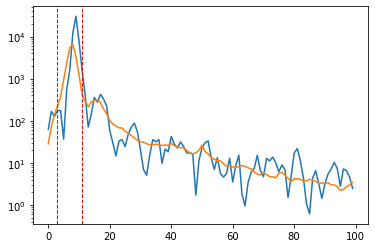

In [9]:
plt.plot(spectrum_phasic[:100])
plt.plot(spectrum_tonic[:100])

plt.axvline(x=4-1, color='r', linestyle='--', linewidth=1)
plt.axvline(x=12-1, color='r', linestyle='--', linewidth=1)

plt.yscale('log')

# Analysis

## Dataset

In [11]:
spectrum_phasic = []
spectrum_tonic = []

for sample in remFolder:
    lfpREMs = sample["data"]
    
    for lfpREM in lfpREMs:
        
        if(len(lfpREM) < 2500): 
            break    #Skip when the duration is less than a second
        
        theta = NeuralSignal(lfpREM, fs)
        theta.filter('lowpass', f_range=f_lowpass, n_seconds=lowpass_length)
        theta.segment(f_range=f_theta, threshold_episode=threshold_episode, threshold_bycycle=threshold_bycycle)
        
        # Combine all tonic episodes for each REM period
        theta_tonic = np.concatenate(theta.get_tonic(filter_type="raw"))
        logger.debug("tonic shape: {0}".format(theta_tonic.shape))
        
        f, spectrum_t = compute_spectrum(theta_tonic, theta.fs, method='welch', avg_type='mean')
        spectrum_tonic.append(spectrum_t[:100])

        if theta.phasic:
            # Combine all phasic episodes for each REM period
            theta_phasic = np.concatenate(theta.get_phasic(filter_type="raw"))
            logger.debug("signal shape: {0}".format(tonic.shape))
            
            f, spectrum_p = compute_spectrum(theta_phasic, theta.fs, method='welch', avg_type='mean')
            spectrum_phasic.append(spectrum_p[:100])
            

spectrum_phasic = np.vstack(spectrum_phasic)
spectrum_tonic = np.vstack(spectrum_tonic)

phasic_spectrum_mean = np.mean(spectrum_phasic, axis=0)
tonic_spectrum_mean = np.mean(spectrum_tonic, axis=0)

phasic_spectrum_std = np.std(spectrum_phasic, axis=0)
tonic_spectrum_std = np.std(spectrum_tonic, axis=0)


/home/miranjo/.local/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 2500 is greater than input length  = 2136, using nperseg = 2136
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/miranjo/.local/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 2500 is greater than input length  = 2426, using nperseg = 2426
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/miranjo/.local/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 2500 is greater than input length  = 2401, using nperseg = 2401
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/miranjo/.local/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 2500 is greater than input length  = 2342, using nperseg = 2342
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/miranjo/.local/lib/python3.10/site-packages/scipy/

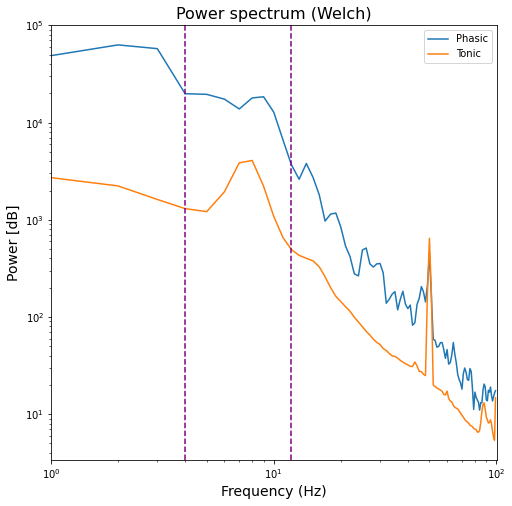

In [81]:
plt.figure(figsize=(8,8))
plt.plot(phasic_spectrum_mean)
plt.plot(tonic_spectrum_mean)

#plt.fill_between(freq, phasic_spectrum_mean - phasic_spectrum_std,
#                 phasic_spectrum_mean + phasic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Phasic Spectrum')
#
#plt.fill_between(freq, tonic_spectrum_mean - tonic_spectrum_std,
#                 tonic_spectrum_mean + tonic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Tonic Spectrum')

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Power [dB]', fontsize=14)

plt.yscale('log')
plt.xscale('log')

plt.xlim((1, 101))

plt.axvline(x=4, color='purple', linestyle='--')
plt.axvline(x=12, color='purple', linestyle='--')

plt.title('Power spectrum (Welch)', fontsize=16)
plt.legend(['Phasic', 'Tonic'])

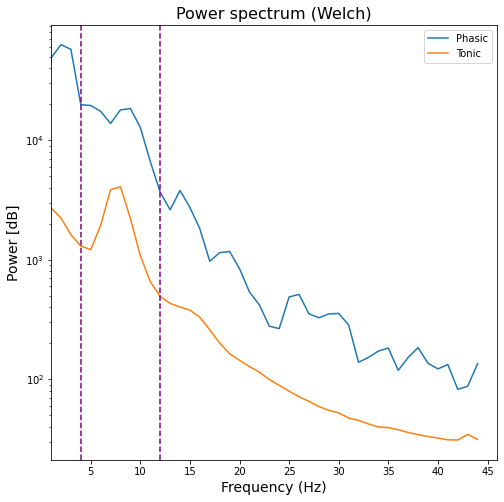

In [74]:
plt.figure(figsize=(8,8))
plt.plot(phasic_spectrum_mean[:45])
plt.plot(tonic_spectrum_mean[:45])

#plt.fill_between(freq, phasic_spectrum_mean - phasic_spectrum_std,
#                 phasic_spectrum_mean + phasic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Phasic Spectrum')
#
#plt.fill_between(freq, tonic_spectrum_mean - tonic_spectrum_std,
#                 tonic_spectrum_mean + tonic_spectrum_std, 
#                 alpha=0.5, label='Standard Deviation of Tonic Spectrum')

plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Power [dB]', fontsize=14)

plt.yscale('log')

plt.xlim((1, 46))

plt.axvline(x=4, color='purple', linestyle='--')
plt.axvline(x=12, color='purple', linestyle='--')

plt.title('Power spectrum (Welch)', fontsize=16)
plt.legend(['Phasic', 'Tonic'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbb09a44430>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbb09a449d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbb09a44160>,
 'medians': [<matplotlib.lines.Line2D at 0x7fbb09a44f70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbb09a45240>,
 'means': []}

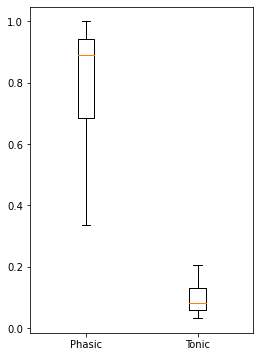

In [86]:
plt.figure(figsize=(4,6))
plt.boxplot([phasic_spectrum_mean[4:12]/phasic_spectrum_mean[4:12].max(),
             tonic_spectrum_mean[4:12]/phasic_spectrum_mean[4:12].max()],
            labels=["Phasic", "Tonic"])

In [80]:
df_phasic = pd.DataFrame(phasic_spectrum_mean)
df_tonic  = pd.DataFrame(tonic_spectrum_mean)

df_phasic.to_excel("spectrum_phasic.xlsx")
df_tonic.to_excel("spectrum_tonic.xlsx")